In [1]:
import numpy as np
from pathlib import Path
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt 
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
%matplotlib inline

import random
seed = 666
random.seed(seed)

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, explained_variance_score
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import KFold

from neuroCombat import neuroCombat
from scipy.stats import pearsonr

import torch
from torch import optim
import torch.utils.data as utils
from torchvision import datasets
torch.manual_seed(seed)

from inv_vae.utils.helpers import Namespace, reset_weights, min_max_standardize, preprocess_neural_data
from inv_vae.models.vae import VAE
from inv_vae.models.inv_vae import INV_VAE

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [2]:
SMALL_SIZE = 15
MEDIUM_SIZE = 25
BIGGER_SIZE = 25

plt.rc('font', size=MEDIUM_SIZE)         
plt.rc('axes', titlesize=MEDIUM_SIZE)     
plt.rc('axes', labelsize=MEDIUM_SIZE)    
plt.rc('xtick', labelsize=MEDIUM_SIZE)   
plt.rc('ytick', labelsize=MEDIUM_SIZE)   
plt.rc('legend', fontsize=MEDIUM_SIZE)   
plt.rc('figure', titlesize=MEDIUM_SIZE)
plt.rc('axes', linewidth = 4.)

load data

In [3]:
n_rois = 68
count_offset = 100
data_dir = Path("/home/yizi/inv-vae/data/hcp/")
hcp_data_dict = np.load(data_dir/"hcp_data_dict.npy", allow_pickle=True).item()
brain_networks = hcp_data_dict["network"] / count_offset
traits = hcp_data_dict["cog"]
avg_trans = np.nanmean(hcp_data_dict["trans"], -1)
avg_rotat = np.nanmean(hcp_data_dict["rotat"], -1)

In [4]:
motion = np.c_[avg_trans, avg_rotat]

In [5]:
pic_vocab = traits[:,6]
pattern_complete = traits[:,10]
pic_seq = traits[:,37]
list_sort = traits[:,35]
fluid_intel = traits[:,2]

In [6]:
drop_ids = (np.isnan(pic_seq) | np.isnan(fluid_intel))
pic_vocab = pic_vocab[~drop_ids]
pattern_complete = pattern_complete[~drop_ids]
list_sort = list_sort[~drop_ids]
pic_seq = pic_seq[~drop_ids]
fluid_intel = fluid_intel[~drop_ids]

brain_networks = brain_networks[~drop_ids].reshape(-1, n_rois*n_rois)
motion = motion[~drop_ids]
n_subs = brain_networks.shape[0]

In [7]:
sub_ids = np.arange(n_subs).reshape(-1,1)
big_motion_ids = sub_ids[motion[:,1] > np.quantile(motion[:,1], .9)]
motion_group = np.zeros(n_subs)
motion_group[big_motion_ids] = 1

In [9]:
fluid_intel /= 100.
lr = LinearRegression().fit(motion, fluid_intel)
yhat = lr.predict(motion)
y_obs = fluid_intel - yhat

lr + pca

In [11]:
kf = KFold(n_splits=5, shuffle=True, random_state=seed)
cv_corr = np.zeros([5])
cv_rmse = np.zeros([5])
for i, (train_index, test_index) in enumerate(kf.split(brain_networks)):
    pca = PCA(n_components=68)
    scaler = StandardScaler()
    std_data = scaler.fit_transform(brain_networks)
    reduced_data = pca.fit_transform(brain_networks)
    reg = LinearRegression().fit(reduced_data[train_index], y_obs[train_index])
    y_pred = reg.predict(reduced_data[test_index])
    cv_corr[i] = pearsonr(y_obs[test_index], y_pred)[0]
    cv_rmse[i] = np.sqrt(mean_squared_error(y_obs[test_index], y_pred))
print("avg cv corr {:.2f} ({:.2f}) ".format(np.mean(cv_corr), np.std(cv_corr)))
print("avg cv rmse {:.2f} ({:.2f}) ".format(np.mean(cv_rmse), np.std(cv_rmse)))
print(list(cv_corr))
print(list(cv_rmse))

avg cv corr 0.09 (0.05) 
avg cv rmse 94.37 (5.91) 
[0.04268450483324371, 0.1266485403127811, 0.16457736731566244, 0.046724869524048904, 0.06836792457552988]
[104.55053032794238, 86.83476836445278, 91.77168499376589, 96.24474279136457, 92.44950991298107]


In [3]:
lr_pic_vocab_corr = [0.25481381497167, 0.12019977039168063, 0.24651325132474808, 0.2469645282354097, 0.018491822715932183]
lr_pattern_complete_corr = [-0.013978220732508196, 0.16502584438646253, 0.007881021478767613, 0.07824412531929857, 0.1012349075277168]
lr_pic_seq_corr = [0.05639675312854049, 0.2130981782677407, 0.0459507567130929, -0.008997356203558703, 0.07873467924729748]
lr_list_sort_corr = [0.23419713855066632, 0.10600941067248315, 0.09047550549078223, -0.0800084833063702, -0.009476973231381788]
lr_fluid_intel_corr = [0.04268450483324371, 0.1266485403127811, 0.16457736731566244, 0.046724869524048904, 0.06836792457552988]

In [ ]:
lr_pic_vocab_rmse = [14.159727407840846, 14.848676390138529, 16.350063463429823, 14.733316895655589, 15.212331478984416]
lr_pattern_complete_rmse = [21.37543378235459, 19.38493513053713, 20.899222092651254, 20.312619250815864, 20.869656005115772]
lr_pic_seq_rmse = [17.846624659957243, 15.837339168030756, 16.96963049342037, 17.39528769853265, 16.722324164980492]
lr_list_sort_rmse = [12.240411207351931, 14.091553264380353, 13.48202480488903, 13.608586840759301, 14.415043259039452]
lr_fluid_intel_rmse = [104.55053032794238, 86.83476836445278, 91.77168499376589, 96.24474279136457, 92.44950991298107]

sog

In [158]:
# save data for running SOG in R
# np.save('./saved_results/hcp_brain_networks.npy', brain_networks)
# np.save('./saved_results/hcp_motion.npy', motion_group)
# np.save('./saved_results/hcp_traits.npy', 
#         np.c_[pic_vocab, pattern_complete, pic_seq, list_sort, fluid_intel])

In [4]:
# load results from SOG with K = 68
sog_pic_vocab_corr = []
sog_pattern_complete_corr = []
sog_pic_seq_corr = []
sog_list_sort_corr = []
sog_fluid_intel_corr = []

combat

In [12]:
covars = {'motion': motion_group} 
covars = pd.DataFrame(covars)  
adjusted_data = neuroCombat(
    dat=np.vstack(brain_networks).transpose(),
    covars=covars,
    batch_col='motion')["data"].transpose()
print(adjusted_data.shape)

[neuroCombat] Creating design matrix
[neuroCombat] Standardizing data across features
[neuroCombat] Fitting L/S model and finding priors
[neuroCombat] Finding parametric adjustments


/home/yizi/anaconda3/envs/inv_vae/lib/python3.8/site-packages/neuroCombat/neuroCombat.py:324: RuntimeWarning: divide by zero encountered in divide
  change = max((abs(g_new - g_old) / g_old).max(), (abs(d_new - d_old) / d_old).max())


[neuroCombat] Final adjustment of data
(1056, 4624)


In [13]:
kf = KFold(n_splits=5, shuffle=True, random_state=seed)
cv_corr = np.zeros([5])
cv_rmse = np.zeros([5])
for i, (train_index, test_index) in enumerate(kf.split(adjusted_data)):
    pca = PCA(n_components=68)
    scaler = StandardScaler()
    std_data = scaler.fit_transform(adjusted_data)
    reduced_data = pca.fit_transform(adjusted_data)
    reg = LinearRegression().fit(reduced_data[train_index], y_obs[train_index])
    y_pred = reg.predict(reduced_data[test_index])
    cv_corr[i] = pearsonr(y_obs[test_index], y_pred)[0]
    cv_rmse[i] = np.sqrt(mean_squared_error(y_obs[test_index], y_pred))
print("avg cv corr {:.2f} ({:.2f}) ".format(np.mean(cv_corr), np.std(cv_corr)))
print("avg cv rmse {:.2f} ({:.2f}) ".format(np.mean(cv_rmse), np.std(cv_rmse)))
print(list(cv_corr))
print(list(cv_rmse))

avg cv corr 0.09 (0.05) 
avg cv rmse 94.32 (5.82) 
[0.05130439781837345, 0.11728578743359118, 0.1690315349752616, 0.049902466009428784, 0.07588619171656794]
[104.45838750824197, 87.0726117890033, 91.66035702679648, 96.06685523607202, 92.34264669671363]


In [5]:
combat_pic_vocab_corr = [0.24595687120386808, 0.10780339456281134, 0.24897799280326666, 0.23063450875657915, 0.005395307575297999]
combat_pattern_complete_corr = [-0.006403000845518001, 0.15483705041360354, 0.0025084401589403373, 0.08751489085620645, 0.09500421042560898]
combat_pic_seq_corr = [0.050950154592762954, 0.2113180239891573, 0.04976883510450947, 0.0055693411671734055, 0.09515017165359912]
combat_list_sort_corr = [0.23921628706984296, 0.10718324803862977, 0.07042426273041016, -0.07313438014519219, -0.005803533953346037]
combat_fluid_intel_corr = [0.05130439781837345, 0.11728578743359118, 0.1690315349752616, 0.049902466009428784, 0.07588619171656794]

In [ ]:
combat_pic_vocab_rmse = [14.181316473076933, 14.927101156672483, 16.31068674317899, 14.841758915562998, 15.394179038764676]
combat_pattern_complete_rmse = [21.3347086613261, 19.4493558129741, 20.95071351092425, 20.266326452598015, 20.894788629499658]
combat_pic_seq_rmse = [17.875268899044393, 15.829086346295727, 16.926918696756697, 17.293399493671313, 16.62963080050113]
combat_list_sort_rmse = [12.212578116031828, 14.08468348436289, 13.559316303315235, 13.615294401117087, 14.405022162179764]
combat_fluid_intel_rmse = [104.45838750824197, 87.0726117890033, 91.66035702679648, 96.06685523607202, 92.34264669671363]

vae

In [14]:
config = Namespace(n_nodes=n_rois, latent_dim=68, hidden_dim=256, nuisance_dim=0,
    n_enc_layers=1, n_dec_layers=3, n_neighbors=32, drop_out=0.,
    beta = 1., add_reg = True, y_dim = 1, 
    batch_size=32, n_epochs=250, lr=1e-5, device=DEVICE)

In [15]:
A_mat = np.mean(brain_networks.reshape(-1,n_rois,n_rois), axis=0)
A_mat = A_mat + A_mat.transpose()
knn_masks = [torch.from_numpy(np.float32(np.argsort(np.argsort(A_mat, axis=-1), axis=-1) < config.n_neighbors+i)).float() for i in range(config.n_dec_layers)]

In [16]:
tensor_nets = torch.stack([torch.Tensor(i) for i in list(brain_networks)]).to(torch.float32).view(-1, config.n_nodes*config.n_nodes)
tensor_motion = torch.from_numpy(motion).to(torch.float32)
tensor_traits = torch.from_numpy(y_obs).to(torch.float32) 

In [17]:
kf = KFold(n_splits=5, shuffle=True, random_state=666)
cv_corr = np.zeros([5])
cv_rmse = np.zeros([5])
for i, (train_index, test_index) in enumerate(kf.split(brain_networks)):
    print(f'running GATE on fold {i+1} ...')
    vae = VAE(config).to(config.device)
    vae.apply(reset_weights)
    vae.set_mask(knn_masks)
    optimizer = optim.Adam(vae.parameters(), lr=config.lr, weight_decay=1e-1) 

    train_set = utils.TensorDataset(tensor_nets[train_index], tensor_motion[train_index], tensor_traits[train_index] )
    test_set = utils.TensorDataset(tensor_nets[test_index], tensor_motion[test_index],  tensor_traits[test_index])
    train_loader = utils.DataLoader(train_set, config.batch_size) 
    test_loader = utils.DataLoader(test_set, config.batch_size)
    
    for epoch in range(config.n_epochs):
        _ = vae.reg_train(epoch, train_loader, vae, optimizer, config.device, n_epoch_display=20)
    _, y_pred, _, _ = vae(tensor_nets[test_index].to(torch.float32).view(-1, config.n_nodes*config.n_nodes).to(config.device))
    cv_corr[i] = pearsonr(y_obs[test_index], y_pred.detach().cpu().numpy().flatten())[0]
    cv_rmse[i] = np.sqrt(mean_squared_error(y_obs[test_index], y_pred.detach().cpu().numpy().flatten()))
    print("test corr: {:.2f}".format(cv_corr[i]))
    print("test rmse: {:.2f}".format(cv_rmse[i]))
print("avg cv corr {:.2f} ({:.2f}) ".format(np.mean(cv_corr), np.std(cv_corr)))
print("avg cv rmse {:.2f} ({:.2f}) ".format(np.mean(cv_rmse), np.std(cv_rmse)))
print(list(cv_corr))
print(list(cv_rmse))

running GATE on fold 1 ...
epoch: 0 train loss: 7466.801 nll: -668.374 kl: 96.449 rmse: 15.796
epoch: 20 train loss: -8988.647 nll: -16979.439 kl: 12.804 rmse: 15.737
epoch: 40 train loss: -9115.625 nll: -16989.758 kl: 20.167 rmse: 15.613
epoch: 60 train loss: -9356.523 nll: -17007.009 kl: 44.073 rmse: 15.363
epoch: 80 train loss: -9688.145 nll: -17032.157 kl: 88.887 rmse: 15.001
epoch: 100 train loss: -10075.781 nll: -17056.977 kl: 148.135 rmse: 14.557
epoch: 120 train loss: -10487.983 nll: -17069.314 kl: 216.594 rmse: 14.048
epoch: 140 train loss: -10915.883 nll: -17076.099 kl: 291.333 rmse: 13.489
epoch: 160 train loss: -11346.494 nll: -17081.361 kl: 368.777 rmse: 12.898
epoch: 180 train loss: -11778.048 nll: -17089.387 kl: 446.170 rmse: 12.281
epoch: 200 train loss: -12198.122 nll: -17097.052 kl: 521.181 rmse: 11.649
epoch: 220 train loss: -12609.535 nll: -17109.711 kl: 592.655 rmse: 11.004
epoch: 240 train loss: -13003.741 nll: -17120.576 kl: 658.701 rmse: 10.351
test corr: 0.02
t

In [6]:
vae_pic_vocab_corr = [0.32116461145396763, 0.16483408801342342, 0.1763688710095428, 0.18803798961358537, 0.16367292974841804]
vae_pattern_complete_corr = [0.018297848030065237, 0.0741663884757398, 0.11199813942992269, 0.007917562461809555, 0.1121932828688083]
vae_pic_seq_corr = [0.06962548304500292, 0.20492371705040643, 0.17578534299318455, 0.050004425596698585, 0.16215441096208266]
vae_list_sort_corr = [0.2770363136513487, 0.1800080629216704, 0.13740136268905997, -0.09099795189035413, 0.11541601896593334]
vae_fluid_intel_corr = [0.020789487655943246, 0.16665080466613125, 0.16928935275852477, 0.054260383343835046, 0.04063967014550966]

In [ ]:
vae_pic_vocab_rmse = [14.087150464386973, 15.197460332843615, 17.282476747435787, 15.539362207410335, 14.782041752837397]
vae_pattern_complete_rmse = [21.360229117666425, 20.29926642553152, 20.505063197187166, 20.756366450712587, 21.06882045138279]
vae_pic_seq_rmse = [17.786751867356084, 15.987566305087261, 16.216404123909147, 16.9450942223509, 16.347368088976758]
vae_list_sort_rmse = [12.229843729120152, 14.099380201410812, 13.77902538075834, 14.915036309586151, 14.336955255809952]
vae_fluid_intel_rmse = [106.71181025089788, 87.60594140608912, 94.91845642639717, 97.63659052935947, 95.11825863449339]

inv-vae

In [21]:
# config = Namespace(n_nodes=68, latent_dim=68, hidden_dim=256, nuisance_dim=2,
#     n_enc_layers=1, n_dec_layers=3, n_neighbors=32, drop_out=0., 
#     beta = .01, gamma = 0., add_reg = True, y_dim = 1,
#     batch_size=32, n_epochs=150, lr=1e-5, device=DEVICE)

config = Namespace(n_nodes=68, latent_dim=68, hidden_dim=256, nuisance_dim=2,
    n_enc_layers=1, n_dec_layers=3, n_neighbors=32, drop_out=0., 
    beta = 100, gamma = .1, add_reg = True, y_dim = 1,
    batch_size=32, n_epochs=250, lr=1e-5, device=DEVICE)

In [22]:
tensor_nets = torch.stack([torch.Tensor(i) for i in list(brain_networks)]).to(torch.float32).view(-1, config.n_nodes*config.n_nodes)
tensor_motion = torch.from_numpy(motion).to(torch.float32)
tensor_traits = torch.from_numpy(y_obs).to(torch.float32) 

In [23]:
kf = KFold(n_splits=5, shuffle=True, random_state=666)
cv_corr = np.zeros([5])
cv_rmse = np.zeros([5])
for i, (train_index, test_index) in enumerate(kf.split(brain_networks)):
    print(f'running inv-VAE on fold {i+1} ...')
    inv_vae = INV_VAE(config).to(config.device)
    inv_vae.apply(reset_weights)
    inv_vae.set_mask(knn_masks)
    optimizer = optim.Adam(inv_vae.parameters(), lr=config.lr, weight_decay=1e-1) 

    train_set = utils.TensorDataset(tensor_nets[train_index], tensor_motion[train_index], tensor_traits[train_index] )
    test_set = utils.TensorDataset(tensor_nets[test_index], tensor_motion[test_index],  tensor_traits[test_index])
    train_loader = utils.DataLoader(train_set, config.batch_size) 
    test_loader = utils.DataLoader(test_set, config.batch_size)
    
    for epoch in range(config.n_epochs):
        _ = inv_vae.reg_train(epoch, train_loader, inv_vae, optimizer, config.device, n_epoch_display=20)
    _, y_pred, _, _ = inv_vae(tensor_nets[test_index].to(torch.float32).view(-1, config.n_nodes*config.n_nodes).to(config.device),
                             tensor_motion[test_index].to(config.device))
    cv_corr[i] = pearsonr(y_obs[test_index], y_pred.detach().cpu().numpy().flatten())[0]
    cv_rmse[i] = np.sqrt(mean_squared_error(y_obs[test_index], y_pred.detach().cpu().numpy().flatten()))
    print("test corr: {:.2f}".format(cv_corr[i]))
    print("test rmse: {:.2f}".format(cv_rmse[i]))
print("avg cv corr {:.2f} ({:.2f}) ".format(np.mean(cv_corr), np.std(cv_corr)))
print("avg cv rmse {:.2f} ({:.2f}) ".format(np.mean(cv_rmse), np.std(cv_rmse)))
print(list(cv_corr))
print(list(cv_rmse))

running inv-VAE on fold 1 ...
epoch: 0 train loss: 8226.506 nll: 461.718 kl: 182.376 inv_loss: 1.385 rmse: 15.801
epoch: 20 train loss: 6326.836 nll: -16976.472 kl: 194.496 inv_loss: 0.262 rmse: 15.759
epoch: 40 train loss: 6237.677 nll: -16983.315 kl: 291.797 inv_loss: 0.264 rmse: 15.670
epoch: 60 train loss: 6036.357 nll: -16983.352 kl: 724.020 inv_loss: 0.311 rmse: 15.462
epoch: 80 train loss: 5696.382 nll: -16983.023 kl: 1954.575 inv_loss: 0.358 rmse: 15.109
epoch: 100 train loss: 5250.140 nll: -16984.485 kl: 4277.335 inv_loss: 0.386 rmse: 14.637
epoch: 120 train loss: 4744.765 nll: -16986.428 kl: 7587.506 inv_loss: 0.396 rmse: 14.090
epoch: 140 train loss: 4215.844 nll: -16987.922 kl: 11717.547 inv_loss: 0.394 rmse: 13.496
epoch: 160 train loss: 3683.467 nll: -16987.548 kl: 16442.814 inv_loss: 0.389 rmse: 12.872
epoch: 180 train loss: 3161.800 nll: -16987.927 kl: 21574.291 inv_loss: 0.380 rmse: 12.229
epoch: 200 train loss: 2655.869 nll: -16987.822 kl: 27101.749 inv_loss: 0.370 rm

In [20]:
inv_pic_vocab_corr = [0.3408235166349346, 0.18377479760444285, 0.23135428142944814, 0.2078194629330899, 0.2296442551744491]
inv_pattern_complete_corr  = [0.00435675836646222, 0.103061928506115, 0.052408276456918076, 0.06653505341288381, 0.16293230323673755]
inv_pic_seq_corr = [0.08114182384575469, 0.21789202010295675, 0.12819005658012736, 0.06887621825097817, 0.2323625762711067]
inv_list_sort_corr = [0.2779611267610784, 0.15771397047336144, 0.2328881199311603, -0.011666067360179633, 0.13614389206790578]
inv_fluid_intel_corr = [0.016335833481099005, 0.18702842333000153, 0.16393074760063875, 0.07313471229907363, 0.027677586579628696]

In [ ]:
inv_pic_vocab_rmse = [13.936918262351721, 14.605893272820797, 16.746287605250778, 15.282727438862377, 14.082709128418646]
inv_pattern_complete_rmse = [21.94071675890447, 20.6302618533686, 21.218487628492902, 20.815951453685077, 20.640844160968243]
inv_pic_seq_rmse = [17.996430898916213, 16.245800986211258, 16.84228340772536, 17.32503289949473, 16.196700327400624]
inv_list_sort_rmse = [12.06111886442831, 13.87153958402313, 12.90996635153562, 13.372555393664552, 13.749986895725984]
inv_fluid_intel_rmse = [104.39091432624383, 86.32464429419905, 93.27909918719274, 95.13017661522039, 94.79403931769427]

error-bar plots

In [8]:
lr_pca = np.c_[lr_pic_vocab_corr, lr_pattern_complete_corr, lr_pic_seq_corr, lr_list_sort_corr, lr_fluid_intel_corr]
combat = np.c_[combat_pic_vocab_corr, combat_pattern_complete_corr, combat_pic_seq_corr, combat_list_sort_corr, combat_fluid_intel_corr]
sog = np.c_[sog_pic_vocab_corr, sog_pattern_complete_corr, sog_pic_seq_corr, sog_list_sort_corr, sog_fluid_intel_corr]
vae = np.c_[vae_pic_vocab_corr, vae_pattern_complete_corr, vae_pic_seq_corr, vae_list_sort_corr, vae_fluid_intel_corr]
inv_vae = np.c_[inv_pic_vocab_corr, inv_pattern_complete_corr, inv_pic_seq_corr, inv_list_sort_corr, inv_fluid_intel_corr]

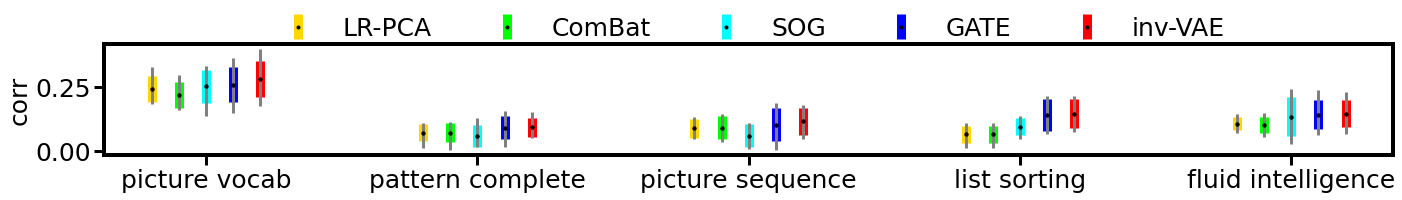

In [44]:
ticks = ['picture vocab', 'pattern complete', 'picture sequence', 'list sorting', 'fluid intelligence']

fig = plt.figure(figsize=(20, 4))
ax = fig.add_subplot(111)

mins, maxs, means, stds = lr_pca.min(0), lr_pca.max(0), lr_pca.mean(0), lr_pca.std(0)
plt.errorbar(np.arange(len(ticks))*2-.4, means, stds, 
                 fmt='.k', ecolor='gold', lw=9, label='LR-PCA')
plt.errorbar(np.arange(len(ticks))*2-.4, means, [means - mins, maxs - means],
                 fmt='.k', ecolor='gray', lw=3)

mins, maxs, means, stds = combat.min(0), combat.max(0), combat.mean(0), combat.std(0)
plt.errorbar(np.arange(len(ticks))*2-.2, means, stds, 
                 fmt='.k', ecolor='lime', lw=9, label='ComBat')
plt.errorbar(np.arange(len(ticks))*2-.2, means, [means - mins, maxs - means],
                 fmt='.k', ecolor='gray', lw=3)

mins, maxs, means, stds = sog.min(0), sog.max(0), sog.mean(0), sog.std(0)
plt.errorbar(np.arange(len(ticks))*2, means, stds, 
                 fmt='.k', ecolor='cyan', lw=9, label='SOG')
plt.errorbar(np.arange(len(ticks))*2, means, [means - mins, maxs - means],
                 fmt='.k', ecolor='gray', lw=3)

mins, maxs, means, stds = vae.min(0), vae.max(0), vae.mean(0), vae.std(0)
plt.errorbar(np.arange(len(ticks))*2+.2, means, stds, 
             fmt='.k', ecolor='blue', lw=9, label='GATE')
plt.errorbar(np.arange(len(ticks))*2+.2, means, [means - mins, maxs - means],
                 fmt='.k', ecolor='gray', lw=3)

mins, maxs, means, stds = inv_vae.min(0), inv_vae.max(0), inv_vae.mean(0), inv_vae.std(0)
plt.errorbar(np.arange(len(ticks))*2+.4, means, stds, 
             fmt='.k', ecolor='red', lw=9, label='inv-VAE')
plt.errorbar(np.arange(len(ticks))*2+.4, means, [means - mins, maxs - means],
                 fmt='.k', ecolor='gray', lw=3)


ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.45), ncol=5, fancybox=False, shadow=False, frameon=False)

ax.set_xticks(np.arange(0, len(ticks) * 2, 2), ticks)
ax.set_xlim(-0.75, len(ticks)*2-1.25)
ax.set_ylabel('corr');

ax.tick_params(axis='both', length=10, width=3)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(4)
    
plt.tight_layout()
# plt.savefig('saved_figs/inv_vae_fig7_hcp.png', facecolor='white', dpi=400)